In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.decomposition import PCA

# Load dataset
file_path = "./dataset/Tweets.csv"  # Replace with your path
df = pd.read_csv(file_path)

# Display dataset overview
print("Dataset Overview:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())

# Check sentiment distribution
print("\nSentiment Distribution:")
print(df['airline_sentiment'].value_counts())


ModuleNotFoundError: No module named 'wordcloud'

<ipython-input-31-2029424418e6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='airline_sentiment', palette='coolwarm')


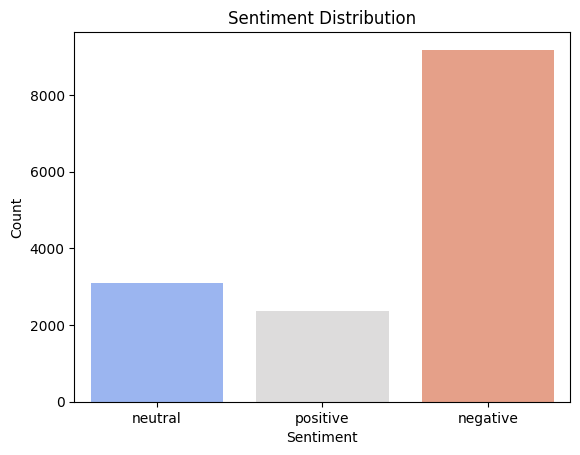

In [31]:
# Sentiment distribution plot
sns.countplot(data=df, x='airline_sentiment', palette='coolwarm')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


<ipython-input-45-f7ac2d51727f>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(neg_word_dict.values()), y=list(neg_word_dict.keys()), palette='Reds_r')
<ipython-input-45-f7ac2d51727f>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(pos_word_dict.values()), y=list(pos_word_dict.keys()), palette='Greens_r')


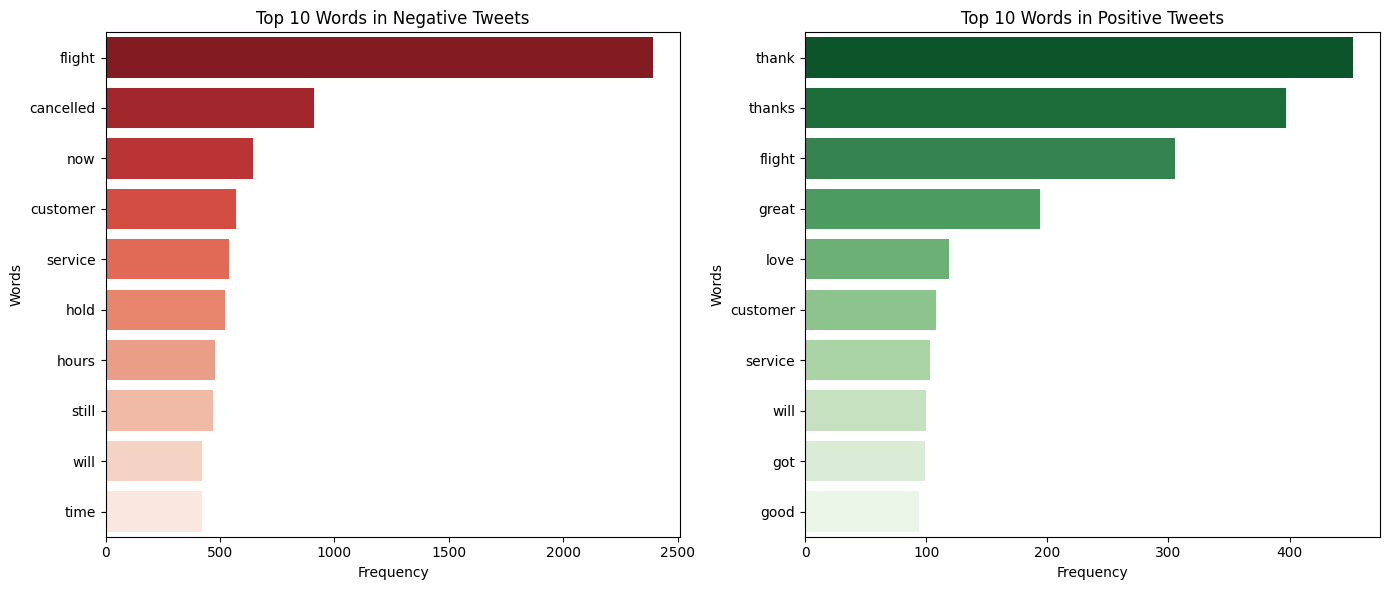

In [45]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS

# Function to preprocess text and extract frequent words
def get_frequent_words(df, sentiment, top_n=7):
    # Combine all text for the current sentiment
    text = " ".join(df[df['airline_sentiment'] == sentiment]['text'])

    # Remove stopwords
    stopwords = set(STOPWORDS)
    words = [word for word in text.lower().split() if word.isalpha() and word not in stopwords]

    # Count word frequencies
    word_counts = Counter(words)

    # Get the most common words
    return word_counts.most_common(top_n)

# Get frequent words for each sentiment
negative_words = get_frequent_words(df, 'negative', top_n=10)
positive_words = get_frequent_words(df, 'positive', top_n=10)

# Convert to dictionaries for visualization
neg_word_dict = dict(negative_words)
pos_word_dict = dict(positive_words)

# Plotting
plt.figure(figsize=(14, 6))

# Bar plot for Negative Sentiment
plt.subplot(1, 2, 1)
sns.barplot(x=list(neg_word_dict.values()), y=list(neg_word_dict.keys()), palette='Reds_r')
plt.title("Top 10 Words in Negative Tweets")
plt.xlabel("Frequency")
plt.ylabel("Words")

# Bar plot for Positive Sentiment
plt.subplot(1, 2, 2)
sns.barplot(x=list(pos_word_dict.values()), y=list(pos_word_dict.keys()), palette='Greens_r')
plt.title("Top 10 Words in Positive Tweets")
plt.xlabel("Frequency")
plt.ylabel("Words")

plt.tight_layout()
plt.show()


In [34]:
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Define stop words
stop_words = set(stopwords.words('english'))

# Extract top words for negative sentiment
negative_text = " ".join(df[df['airline_sentiment'] == 'negative']['text'])
words = [word for word in negative_text.split() if word.lower() not in stop_words]
most_common_words = Counter(words).most_common(7)

# Display top words
print("Top 7 words in negative tweets:")
for word, count in most_common_words:
    print(f"{word}: {count}")


[nltk_data] Downloading package stopwords to /root/nltk_data...


Top 7 words in negative tweets:
@united: 2510
@USAirways: 2207
@AmericanAir: 2035
flight: 1915
@SouthwestAir: 1157
get: 945
Cancelled: 912


[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
# Preprocessing
df['text'] = df['text'].fillna("").str.lower()

# Feature extraction
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['text'])

# Encode sentiment labels
y = df['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})


In [29]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      1889
           1       0.64      0.48      0.55       580
           2       0.78      0.66      0.71       459

    accuracy                           0.79      2928
   macro avg       0.75      0.69      0.71      2928
weighted avg       0.78      0.79      0.78      2928



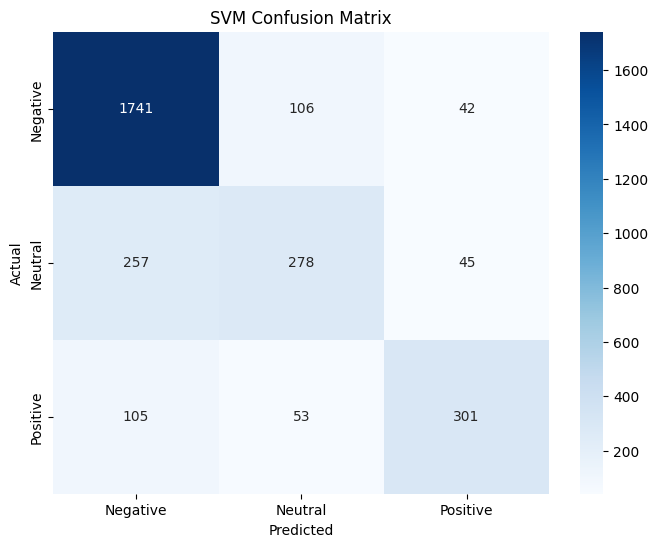

In [36]:
# Train SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Evaluate SVM
y_pred_svm = svm_model.predict(X_test)

# Classification report and accuracy
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [39]:
from keras.utils import to_categorical

# Define model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train MLNN
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate MLNN
mlnn_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print("MLNN Accuracy:", mlnn_accuracy)


Epoch 1/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6443 - loss: 0.8416 - val_accuracy: 0.7729 - val_loss: 0.5513
Epoch 2/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8467 - loss: 0.4193 - val_accuracy: 0.7580 - val_loss: 0.5794
Epoch 3/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9049 - loss: 0.2742 - val_accuracy: 0.7636 - val_loss: 0.6410
Epoch 4/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9374 - loss: 0.1895 - val_accuracy: 0.7593 - val_loss: 0.7296
Epoch 5/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9600 - loss: 0.1312 - val_accuracy: 0.7542 - val_loss: 0.8683
Epoch 6/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9730 - loss: 0.0894 - val_accuracy: 0.7507 - val_loss: 0.9949
Epoch 7/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9821 - loss: 0.0645 - val_accuracy: 0.7490 - val_loss: 1.0691
Epoch 8/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9854 - loss: 0.0507 - val_accu

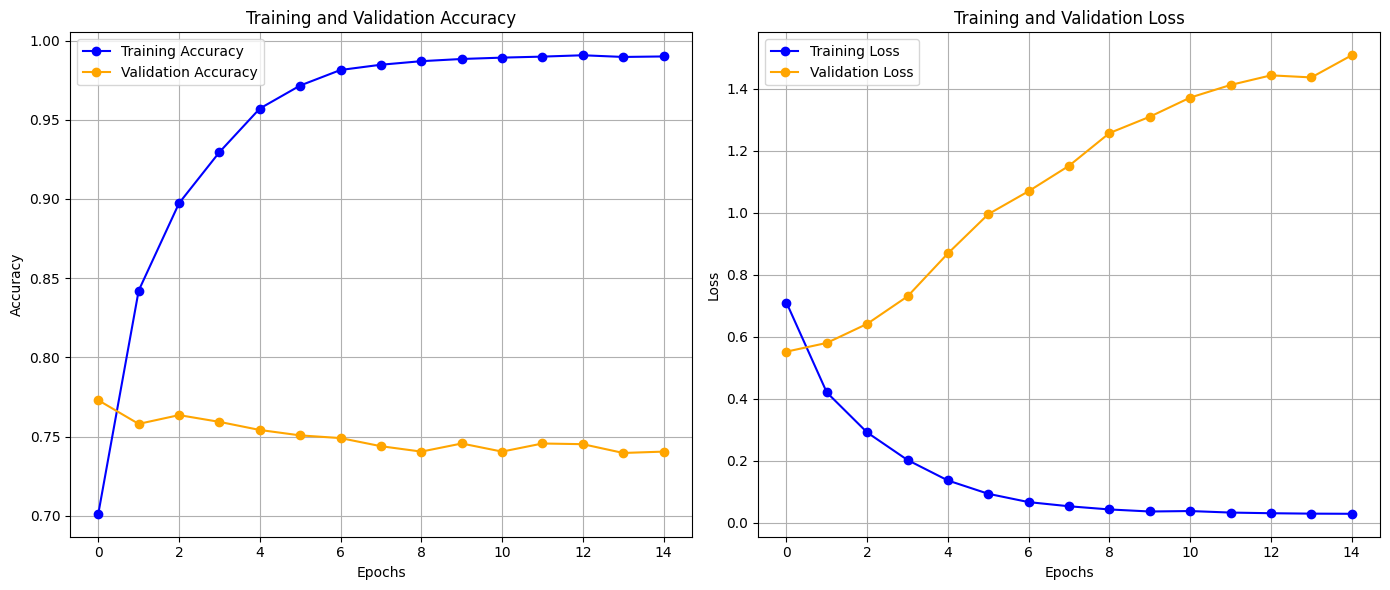

In [40]:
# Plot training and validation metrics
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='o')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


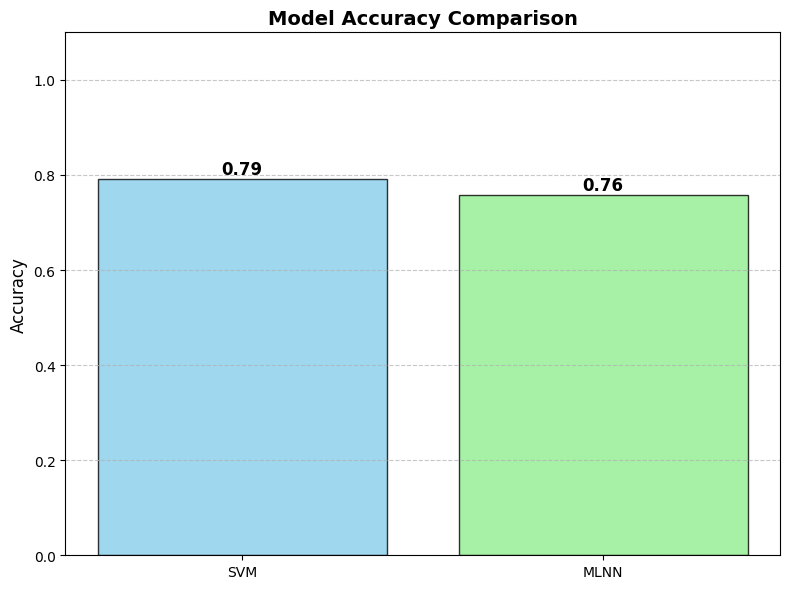

In [42]:
# Model accuracies
model_names = ['SVM', 'MLNN']
accuracies = [svm_accuracy, mlnn_accuracy]

# Plot bar chart
plt.figure(figsize=(8, 6))
colors = ['skyblue', 'lightgreen']
plt.bar(model_names, accuracies, color=colors, edgecolor='black', alpha=0.8)

# Annotate the accuracy values on top of each bar
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.01, f"{accuracy:.2f}", ha='center', fontsize=12, fontweight='bold')

# Add titles and labels
plt.title("Model Accuracy Comparison", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1.1)  # Ensures space for annotations above bars
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

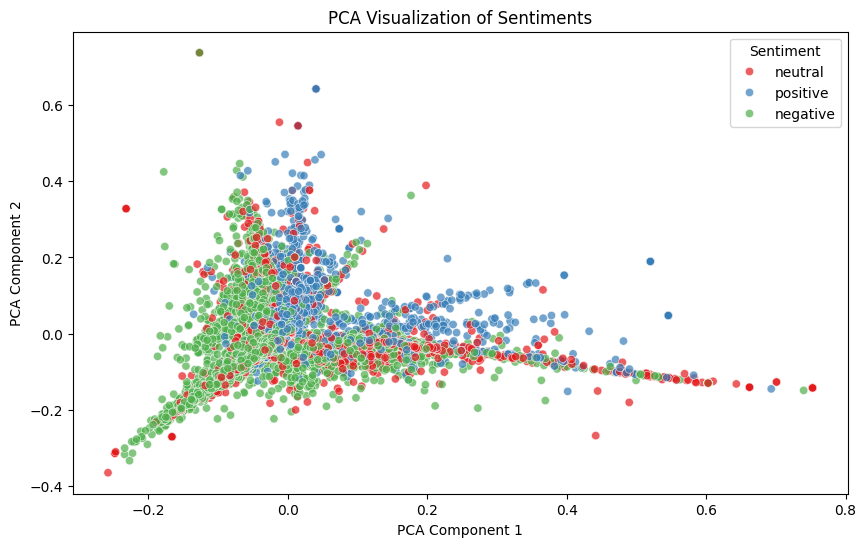

In [43]:
# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['airline_sentiment'], palette='Set1', alpha=0.7)
plt.title("PCA Visualization of Sentiments")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Sentiment")
plt.show()


<ipython-input-44-7319be902826>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features, y=top_features.index, palette='coolwarm')


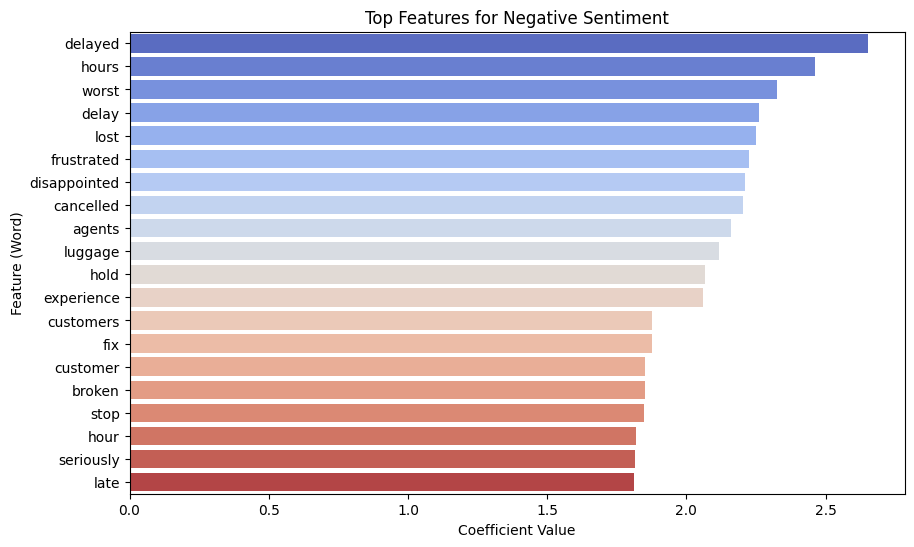

<ipython-input-44-7319be902826>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features, y=top_features.index, palette='coolwarm')


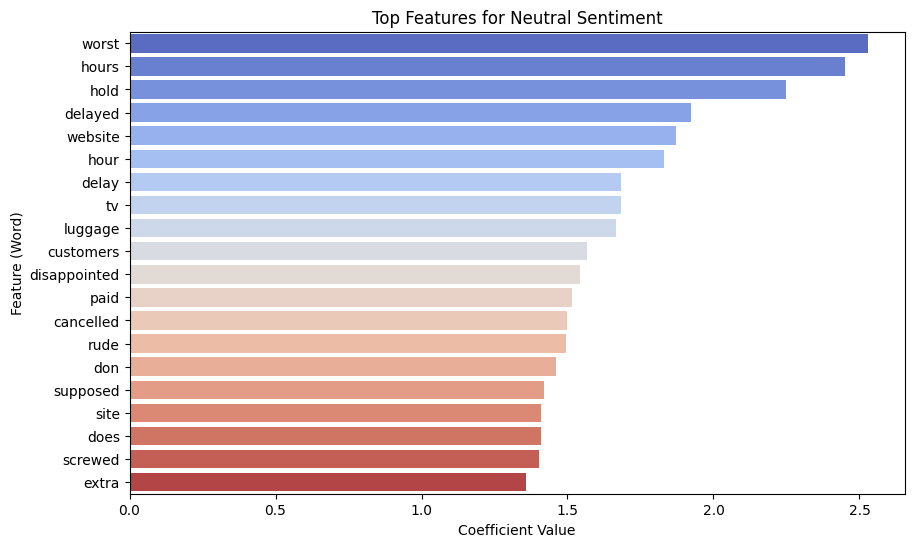

<ipython-input-44-7319be902826>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features, y=top_features.index, palette='coolwarm')


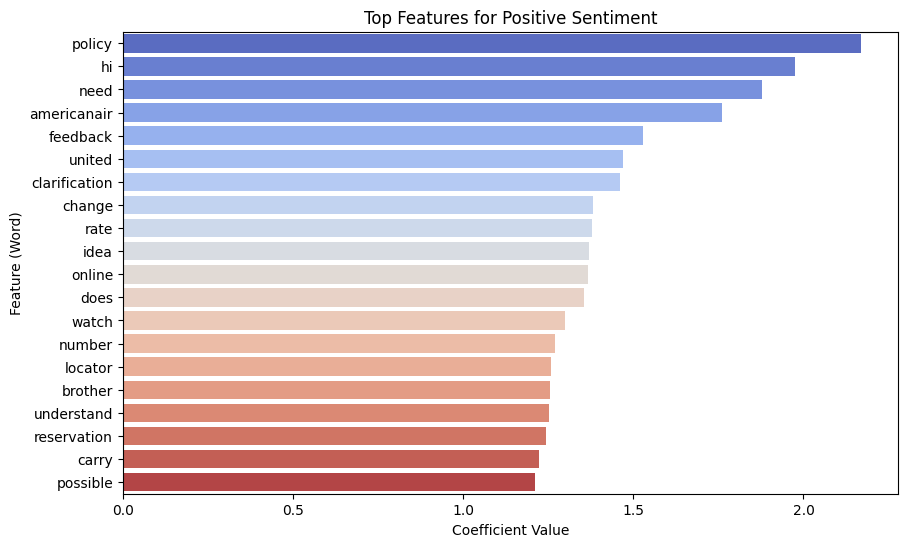

In [44]:
# Extract SVM coefficients
coef = svm_model.coef_.toarray()
important_words = vectorizer.get_feature_names_out()

# Feature importance visualization
sentiment_labels = ['Negative', 'Neutral', 'Positive']
coef_df = pd.DataFrame(coef.T, columns=sentiment_labels, index=important_words)

for sentiment in sentiment_labels:
    top_features = coef_df[sentiment].sort_values(ascending=False).head(20)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_features, y=top_features.index, palette='coolwarm')
    plt.title(f"Top Features for {sentiment.capitalize()} Sentiment")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature (Word)")
    plt.show()


SVM Accuracy: 0.7923497267759563
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      1889
           1       0.64      0.48      0.55       580
           2       0.78      0.66      0.71       459

    accuracy                           0.79      2928
   macro avg       0.75      0.69      0.71      2928
weighted avg       0.78      0.79      0.78      2928



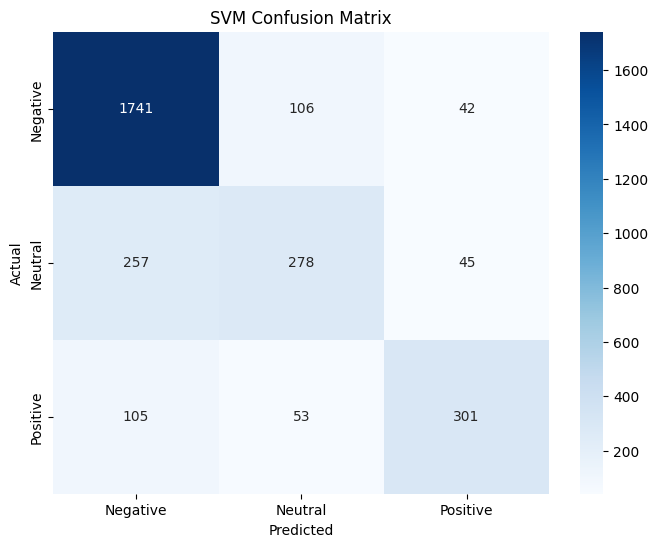

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Predict using the trained SVM model
svm_predictions = svm_model.predict(X_test)

# Calculate accuracy
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

# Print classification report
print("SVM Classification Report:\n", classification_report(y_test, svm_predictions))

# Confusion matrix for SVM
conf_matrix = confusion_matrix(y_test, svm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# Step 14: Dimensionality Reduction Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['airline_sentiment'], palette='Set1', alpha=0.7)
plt.title("PCA Visualization of Sentiments")
plt.show()


Sentiment Labels and Their Corresponding Coefficients:
      Negative   Neutral  Positive
00    0.692508  0.347035  0.317639
000   0.233756 -0.614799 -0.209793
0016  0.000000  0.000000  0.000000
00pm  0.396743  0.351630  0.000000
02    0.687584  0.016727  0.000000


<ipython-input-23-7836ac2584bb>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features, y=top_features.index, palette='coolwarm')


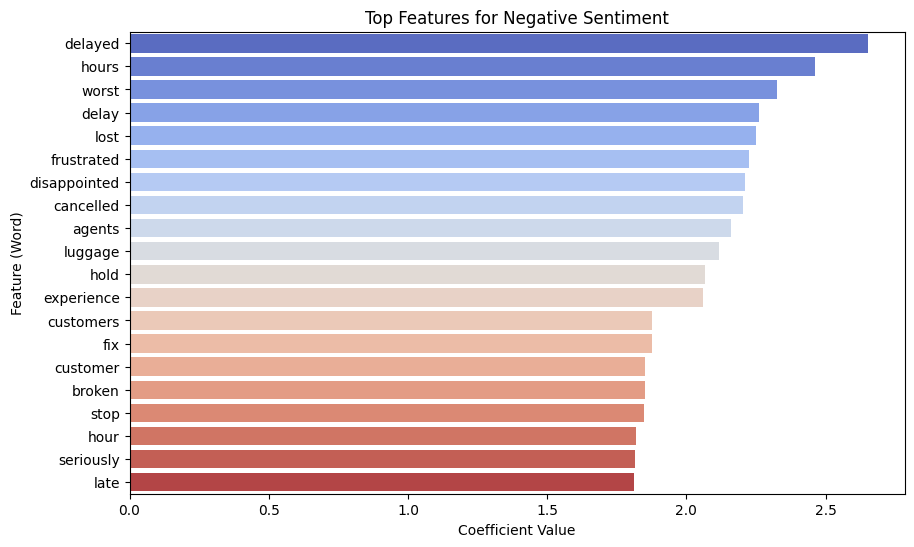

<ipython-input-23-7836ac2584bb>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features, y=top_features.index, palette='coolwarm')


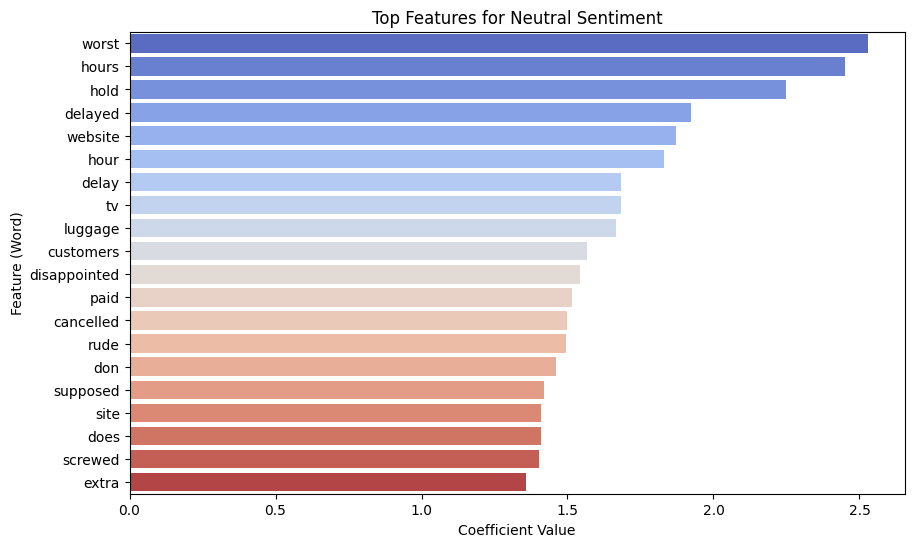

<ipython-input-23-7836ac2584bb>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features, y=top_features.index, palette='coolwarm')


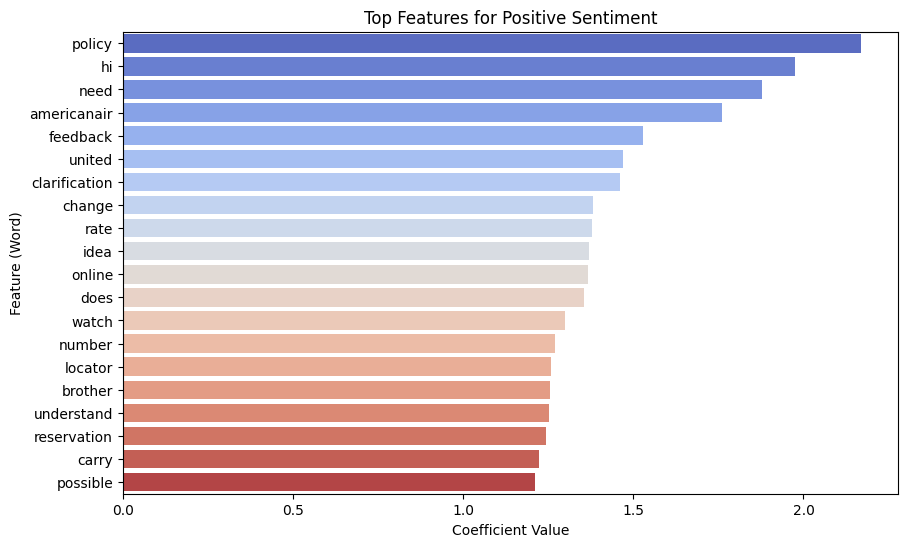

In [23]:
# Extract coefficients and words
coef = svm_model.coef_.toarray()
important_words = vectorizer.get_feature_names_out()

# Validate sentiment alignment
sentiment_labels = ['Negative', 'Neutral', 'Positive']  # Ensure these align with your model's output order
coef_df = pd.DataFrame(coef.T, columns=sentiment_labels, index=important_words)

# Inspect columns to ensure they are correctly aligned
print("Sentiment Labels and Their Corresponding Coefficients:")
print(coef_df.head())

# Visualize top features for each sentiment
for sentiment in sentiment_labels:
    # Sort words by importance for the current sentiment
    top_features = coef_df[sentiment].sort_values(ascending=False).head(20)

    # Display the top features as a bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_features, y=top_features.index, palette='coolwarm')
    plt.title(f"Top Features for {sentiment.capitalize()} Sentiment")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature (Word)")
    plt.show()
